In [1]:
import numpy as np
from scipy import linalg as la
import pandas as pd
from drazin import *
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm
from itertools import product

%matplotlib inline

In [2]:
p = pd.read_csv('combined_cleaned.csv')

p.drop(p[p.Team=='- - -'].index, inplace=True)
p

,Unnamed: 0,Name,Change_Type,Pos,Season,Team,playerid
0,12749,Alfredo Amezaga,Arrive,FD,2002,Angels,1
1,11355,Alfredo Amezaga,No Change,FD,2003,Angels,1
2,7809,Alfredo Amezaga,Leave,FD,2004,Angels,1
3,6220,Alfredo Amezaga,Arrive,FD,2006,Marlins,1
4,5311,Alfredo Amezaga,No Change,FD,2007,Marlins,1
5,6957,Alfredo Amezaga,No Change,FD,2008,Marlins,1
6,8591,Alfredo Amezaga,Leave,FD,2009,Marlins,1
8,13197,Garret Anderson,Arrive,FD,2002,Angels,2
9,6676,Garret Anderson,No Change,FD,2003,Angels,2
10,17104,Garret Anderson,No Change,FD,2004,Angels,2


## Choose 2008,2009,2010 as a snapshot

In [3]:
p08 = p[p.Season.isin(range(2008,1+2011))]
p08.drop(p08[p08.Team=='- - -'].index, inplace=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
num_p = len(p08.playerid.unique())
num_t = len(p08.Team.unique())

A = np.zeros((num_t, num_p))

In [5]:
p_dct = {v:k for k,v in enumerate(p08.playerid.unique())}
t_dct = {v:k for k,v in enumerate(p08.Team.unique())}

t = [0]*len(t_dct)
for team,num in t_dct.items():
    t[num] = team

In [6]:
for idx in p08.index:
    i = t_dct[p08.get_value(idx,'Team')]
    j = p_dct[p08.get_value(idx,'playerid')]
    
    A[i,j] += 1

In [7]:
p_all_dct = {v:k for k,v in enumerate(p.playerid.unique())}
n = len(p_all_dct)
p2p_roles = np.zeros((n,n))

In [8]:
p_teams = p[p.Team != '- - -']
by_season_team_chg = p_teams.groupby(['Season', 'Team', 'Change_Type'])
for yi,ti in tqdm(product(range(2003, 1+2015), t)):
    arrived = by_season_team_chg.get_group((yi,ti,'Arrive'))
    #print(arrived)
    if (yi,ti,'Arrive Leave') in by_season_team_chg.groups:
        arrived = pd.concat([arrived, by_season_team_chg.get_group((yi,ti,'Arrive Leave'))])
        #print(arrived.sample)
    try:
        leave = by_season_team_chg.get_group((yi-1,ti,'Leave'))
    except:
        leave = pd.DataFrame()
    if (yi-1,ti,'Arrive Leave') in by_season_team_chg.groups:
        leave = pd.concat([leave, by_season_team_chg.get_group((yi-1,ti,'Arrive Leave'))])
    #print(arrived['playerid'], leave)
    #if not arrived or not leave:
    #    continue
    for pid1, pid2 in product(arrived['playerid'].values, leave['playerid'].values):
        #print("in loop: ", pid1, pid2, p_all_dct[pid1])
        p2p_roles[p_all_dct[pid1], p_all_dct[pid2]] += 1
        p2p_roles[p_all_dct[pid2], p_all_dct[pid1]] += 1

390it [00:01, 348.43it/s]


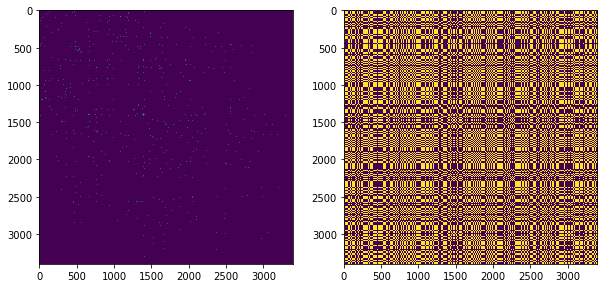

In [9]:
r_dct = {v:k for k,v in enumerate(p.Pos.unique())}
p2r = np.zeros((n,len(r_dct)))
by_player = p.groupby('playerid')
for pid,i in p_all_dct.items():
    role = p[p.playerid==pid]['Pos'].values[0]
    p2r[i, r_dct[role]] = 1
orig = p2r.dot(p2r.T)

plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(p2p_roles)
plt.subplot(122)
plt.imshow(orig)

In [10]:
u,s,vt = np.linalg.svd(p2p_roles)
print(u.shape,s.shape, vt.shape )

(3399, 3399) (3399,) (3399, 3399)


In [11]:
uc, sc, vtc = u.copy(), s.copy(), vt.copy()


In [12]:
sc[4:] = 0


In [13]:
img = uc.dot(np.diag(sc).dot(vtc))

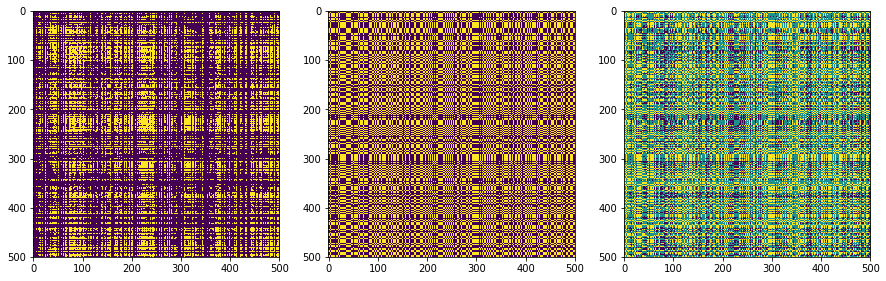

In [14]:
imgc = img[:500,:500].copy()
imgc[imgc>0.02] = 1
imgc[imgc<0.02] = 0
plt.figure(figsize=(15,20))
plt.subplot(131)
plt.imshow(imgc)
plt.subplot(132)
plt.imshow(orig[:500,:500])
plt.subplot(133)
plt.imshow(orig[:500,:500]-imgc)

In [15]:
from collections import Counter
Counter((orig[:500,:500]-imgc).ravel())

Counter({-1.0: 41602, 0.0: 131534, 1.0: 76864})

In [16]:
Counter((orig[:500,:500]).ravel())

Counter({0.0: 145416, 1.0: 104584})

## SVD Stuff

In [55]:
u, s, vT = np.linalg.svd(A)

In [57]:
s[6:] = 0

In [59]:
idx = np.diag_indices(min(A.shape))
sigma = np.zeros_like(A)
sigma[idx] = s

In [66]:
np.average(u.dot(sigma.dot(vT)) - A)

-0.005383913329110571

In [74]:
roles_v = 6
fingerprint = np.ones((num_t, roles_v))
rank = 5

In [76]:
u_trunc = u[:,:rank]
s_trunc = s[:rank]
vT_trunc = vT[:rank]

In [84]:
u_trunc.dot(np.diag(s_trunc).dot(vT_trunc))

array([[  3.21003366e-02,   6.14385073e-02,   2.36294758e-01, ...,
          1.34895795e-02,   6.54038574e-02,  -4.36840794e-04],
       [  2.04795024e-02,   6.54166965e-02,   5.89241355e-02, ...,
          1.27336418e-02,   5.21588320e-02,   4.44101072e-03],
       [  7.87649194e-02,   5.89241355e-02,   1.05354548e+00, ...,
          2.22945673e-02,  -9.24581599e-03,   4.51280091e-02],
       ..., 
       [ -4.36840794e-04,   1.33230322e-02,   1.35384027e-01, ...,
          1.48973929e-02,  -5.50748339e-02,   1.24352171e-01],
       [  3.13915722e-02,   6.62612491e-02,   2.51709063e-01, ...,
          1.46301025e-02,   4.28259717e-03,   1.79171238e-02],
       [  2.20620599e-02,   4.21882255e-02,   1.83685438e-01, ...,
          9.66047559e-03,   2.52630029e-02,   7.78016709e-03]])

In [105]:
s_inv = np.linalg.inv(np.diag(s_trunc))
roles = vT_trunc.T.dot(s_inv.dot(u_trunc.T.dot(fingerprint)))

In [99]:
vT_trunc.T.shape

(1357, 5)

In [103]:
np.linalg.inv(np.diag(s_trunc))

array([[ 0.06771039,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.06992739,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.07071974,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.07089596,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.07125405]])

In [104]:
u_trunc.T.dot(fingerprint).shape

(5, 6)

In [106]:
roles

array([[ 0.00346089,  0.00346089,  0.00346089,  0.00346089,  0.00346089,
         0.00346089],
       [ 0.00914008,  0.00914008,  0.00914008,  0.00914008,  0.00914008,
         0.00914008],
       [ 0.02321023,  0.02321023,  0.02321023,  0.02321023,  0.02321023,
         0.02321023],
       ..., 
       [ 0.00220765,  0.00220765,  0.00220765,  0.00220765,  0.00220765,
         0.00220765],
       [ 0.00565527,  0.00565527,  0.00565527,  0.00565527,  0.00565527,
         0.00565527],
       [ 0.00404481,  0.00404481,  0.00404481,  0.00404481,  0.00404481,
         0.00404481]])

In [ ]:
for k,v in p_dct.items():
    if v==:
        print(k)
        break

## Graphs

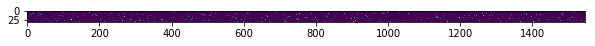

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(A)
plt.show()

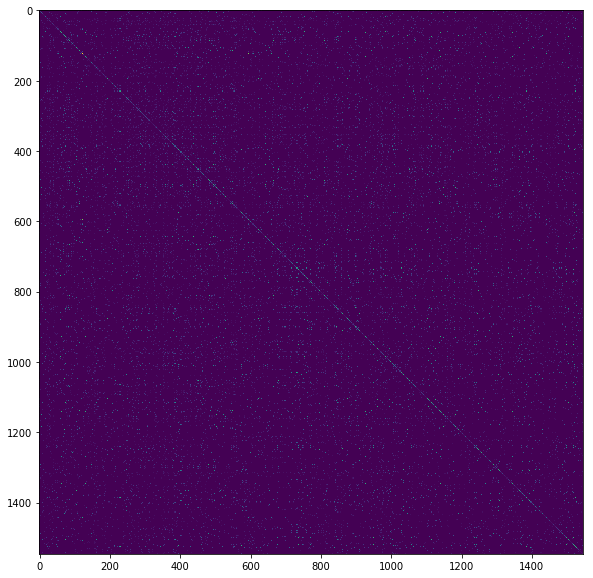

In [8]:
plt.figure(figsize=(10,10))
p2p = A.T.dot(A)
plt.imshow(p2p)
plt.show()

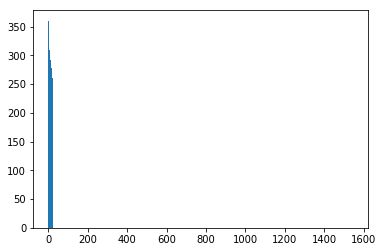

In [34]:
eig, vec = np.linalg.eig(A.T.dot(A))
order = np.argsort(np.real(eig))[::-1]
plt.bar(np.argsort(order), np.real(eig))
plt.show()

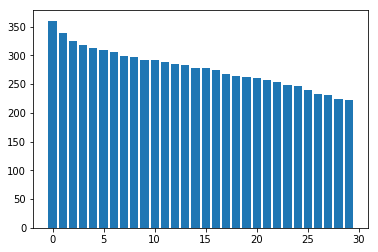

In [30]:
eig, vec = np.linalg.eig(A.dot(A.T))
order = np.argsort(np.abs(eig))[::-1]
plt.bar(np.argsort(order), np.abs(eig))
plt.show()

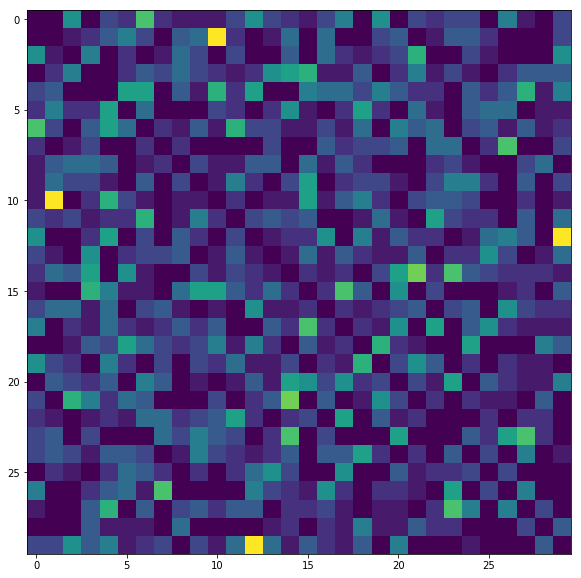

In [9]:
plt.figure(figsize=(10,10))
t2t = A.dot(A.T)
t2t[t2t>100] = 0
plt.imshow(t2t)
plt.show()

In [10]:
d_t = drazin_inverse(t2t)
er = effective_res(t2t)

0 of 30
1 of 30
2 of 30
3 of 30
4 of 30
5 of 30
6 of 30
7 of 30
8 of 30
9 of 30
10 of 30
11 of 30
12 of 30
13 of 30
14 of 30
15 of 30
16 of 30
17 of 30
18 of 30
19 of 30
20 of 30
21 of 30
22 of 30
23 of 30
24 of 30
25 of 30
26 of 30
27 of 30
28 of 30
29 of 30


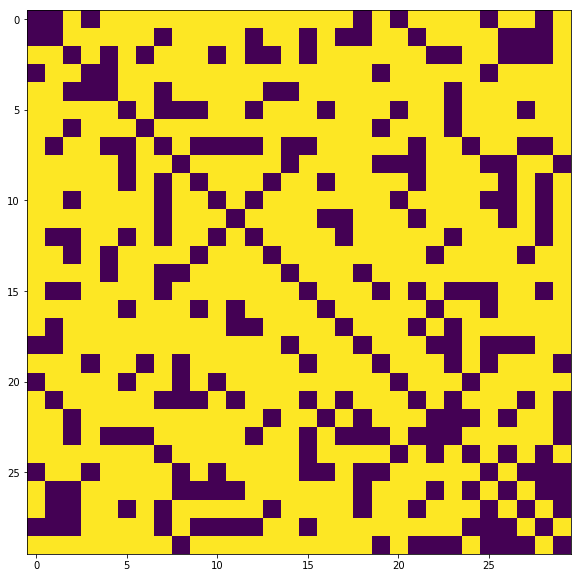

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(t2t>0)
plt.show()

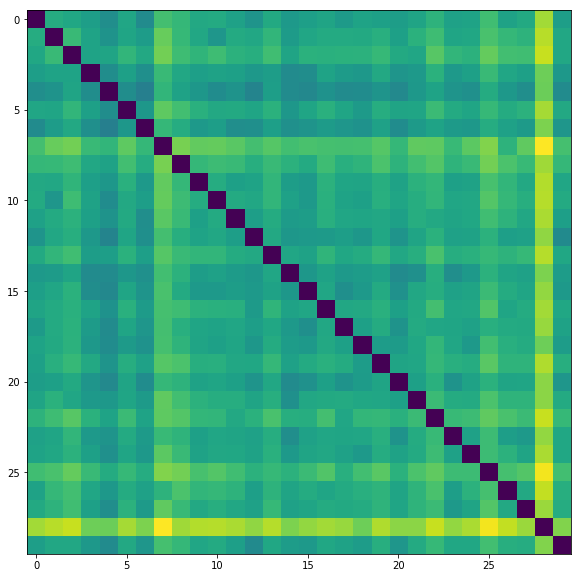

0.0251771506288 0.0294476142987


In [12]:
plt.figure(figsize=(10,10))
plt.imshow(er)
plt.show()
print(er[11,9], er[7,6])

In [13]:
LP = LinkPredictor()
LP.res = er
LP.A = t2t
LP.names = [t_dct[i] for i in t]

In [14]:
LP.predict_link()

(4, 14)

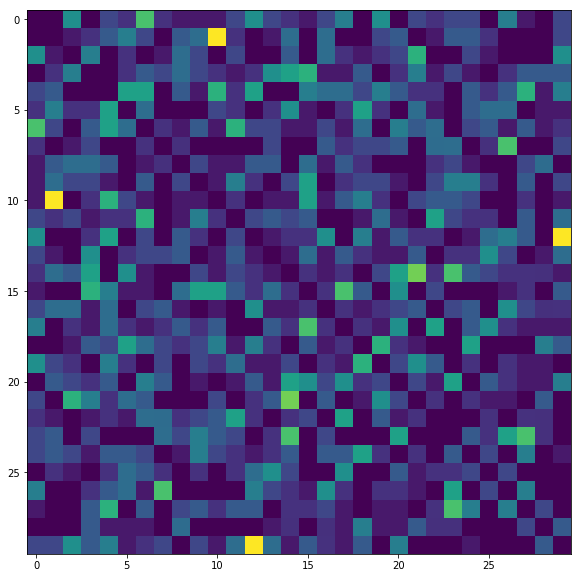

0 0.0 0.0


In [15]:
plt.figure(figsize=(10,10))
dif = t2t-er
dif[t2t<0.02] = 0
plt.imshow(dif)
plt.show()
midx = dif.argmin()
print(midx, dif.ravel()[midx], dif[12][12])
#dif.ravel()[midx]

In [16]:
p.Change_Type.unique()

array(['Arrive', 'No Change', 'Leave', 'Arrive Leave'], dtype=object)

In [17]:
p.sort_values(by=['playerid', 'Season'], inplace=True)